In [28]:
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
np.random.seed(3)

In [29]:
# Load environment
data_folder = Path("data/")
building_attributes = data_folder / 'building_attributes.json'
solar_profile = data_folder / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ["Building_9"] #,"Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
env = CityLearn(building_attributes, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = ['ramping','1-load_factor','peak_to_valley_ratio','peak_demand','net_electricity_consumption'])
observations_spaces,actions_spaces = env.get_state_action_spaces()

In [30]:
#NO STORAGE
env.reset()
done = False
while not done:
    _, rewards, done, _ = env.step([[0 for _ in range(len(actions_spaces[i].sample()))] for i in range(len(building_ids))])
cost_no_es = env.cost()

In [31]:
cost_no_es # costs from CityLearn with no Energy Storage

{'ramping': 0.8378244162397581,
 '1-load_factor': 1.212121045997266,
 'peak_to_valley_ratio': 1.7903095968185958,
 'peak_demand': 1.182624754437011,
 'net_electricity_consumption': 1.0190346967430906,
 'total': 1.2083829020471444}

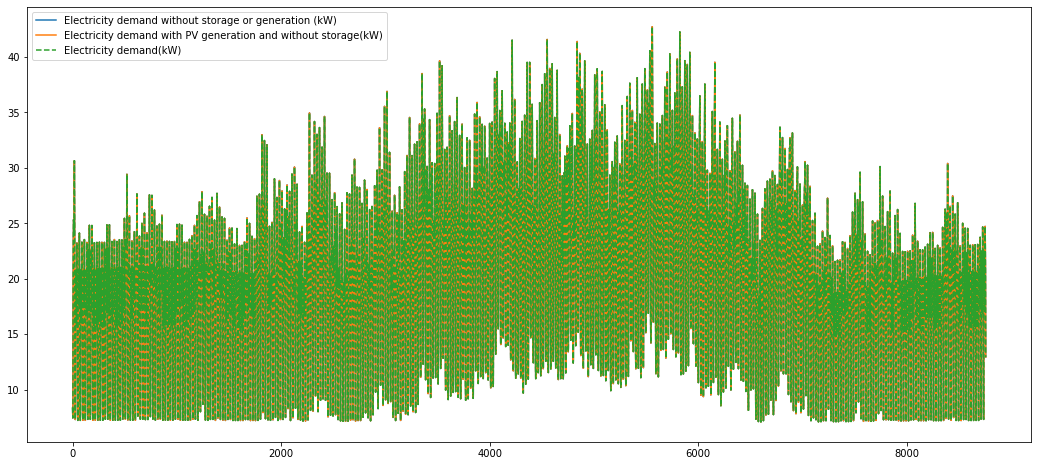

In [32]:
interval = range(0,8759)
plt.figure(figsize=(18,8))
plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand(kW)'])

In [33]:
#RULE-BASED CONTROLLER (Stores energy at night and releases it during the day)
from citylearn import RBC_Agent

#Instantiatiing the control agent(s)
agents = RBC_Agent(actions_spaces)

state = env.reset()
done = False
while not done:
    action = agents.select_action(state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
cost_rbc = env.cost()

In [34]:
cost_rbc #cost from CityLearn with Energy Storage and using a Rule-based controller (can be compared with the RL controller for benchmarking) 15918.64

{'ramping': 1.0,
 '1-load_factor': 1.0,
 'peak_to_valley_ratio': 1.0,
 'peak_demand': 1.0,
 'net_electricity_consumption': 1.0,
 'total': 1.0}

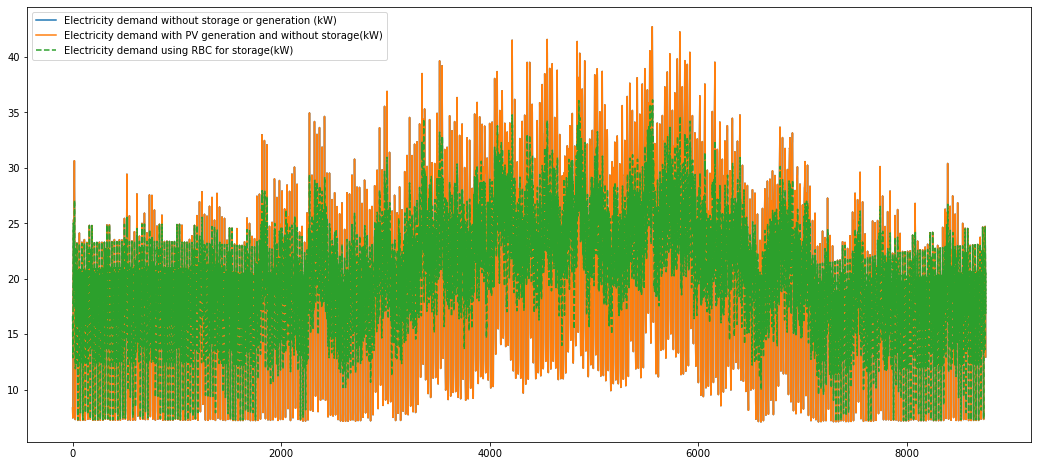

In [35]:
interval = range(0,8759)
plt.figure(figsize=(18,8))
plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand using RBC for storage(kW)'])